# Persistent network

- a network that fires even if the stimulus lasts few instants (aka, there's no decay...)

In [9]:
# fileName

fileName = 'eg_persistent_network'

In [10]:
# libs

import pyNN.brian2 as sim
from pyNN import space 
import numpy as np
import matplotlib.pyplot as plt


In [11]:
# simulation settings

sim.setup(
        timestep=1, # [ms]
        min_delay=1, # [ms]
        max_delay=100) # [ms]

simtime = 250 #ms

In [12]:
# defining the network

pops = {}
n_cells = {}
neuron_Model = {}
neuron_ModelPars = {}
initial_Values = {}

for popName in ['Exc', 'Inh']:
    n_cells[popName] = 100
    neuron_Model[popName] = sim.IF_cond_exp
    neuron_ModelPars[popName] = sim.IF_cond_exp.default_parameters # or standard_pars or testing_pars
    initial_Values[popName] = sim.IF_cond_exp.default_initial_values
    pops[popName] = sim.Population(n_cells[popName], 
                                   neuron_Model[popName],
                                   neuron_ModelPars[popName],
                                   structure = space.Line(dx=1.0, x0=0.0, y=0.0, z=0.0),
                                   label = popName)

    pops[popName].record(['spikes','v','gsyn_exc','gsyn_inh'])   
 
pops

{'Exc': Population(100, IF_cond_exp(<parameters>), structure=Line(dx=1.0, x0=0.0, y=0.0, z=0.0), label='Exc'),
 'Inh': Population(100, IF_cond_exp(<parameters>), structure=Line(dx=1.0, x0=0.0, y=0.0, z=0.0), label='Inh')}

In [13]:
# defining the list of connections

def compute_manual_list(n_cells_i, n_cells_j, weights, d_thresh, p_thresh, width): 
        v_c = 0.35 #m/s
        d0 = 1 #ms
        scale = 1

        connections = {}
        probabilities = {}
        distances = {}

        connections = []
        probabilities = []
        distances = []
        for pre in range(n_cells_i):
            for post in range(n_cells_j):
                d_ij = np.sqrt((pre - post)**2)
                delay = d0 + d_ij / v_c
                if d_ij > d_thresh: 
                    distances.append(d_ij)
                    p_ij = scale*np.exp(-0.5 * (d_ij**2/width**2))
                    probabilities.append(p_ij)

                    if p_ij > p_thresh:
                        connections.append([pre, post, weights, delay])#, [d_ij, p_ij]])

        return connections, distances, probabilities


In [14]:
# compute manual list of connections to have center-surround structure

weight = {('Exc', 'Exc') : 0.08,
          ('Exc', 'Inh') : 0.08,
          ('Inh', 'Exc') : 0.24,
          ('Inh', 'Inh') : 0.24          
          }

d_thresh = {('Exc', 'Exc'): 0, 
            ('Inh', 'Exc'): 2} 

p_thresh = {('Exc', 'Exc'): 0.1, 
            ('Inh', 'Exc'): 0.1}

width = {('Exc', 'Exc'): 1,
         ('Inh', 'Exc'): 3} 



connections = {}
distances = {}
probabilities = {}

connections['Exc', 'Exc'], distances['Exc', 'Exc'], probabilities['Exc', 'Exc'] = compute_manual_list(n_cells['Exc'], 
                                                                                                      n_cells['Exc'], 
                                                                                                      weight['Exc', 'Exc'], 
                                                                                                      d_thresh['Exc', 'Exc'], 
                                                                                                      p_thresh['Exc', 'Exc'], 
                                                                                                      width['Exc', 'Exc'])

connections['Inh', 'Exc'], distances['Inh', 'Exc'], probabilities['Inh', 'Exc'] = compute_manual_list(n_cells['Inh'], 
                                                                                                      n_cells['Exc'], 
                                                                                                      weight['Inh', 'Exc'], 
                                                                                                      d_thresh['Inh', 'Exc'], 
                                                                                                      p_thresh['Inh', 'Exc'], 
                                                                                                      width['Inh', 'Exc'])

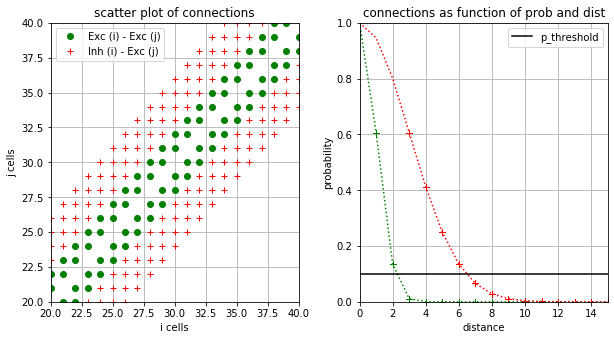

In [15]:
# visual check of the connections

fig, ax = plt.subplots(1,2, figsize=(9,5))
fig.tight_layout(pad=3)
axes_list = fig.axes

axes_list[0].plot(np.asarray(connections['Exc', 'Exc']).T[0], np.asarray(connections['Exc', 'Exc']).T[1],'go', label='Exc (i) - Exc (j)')
axes_list[0].plot(np.asarray(connections['Inh', 'Exc']).T[0], np.asarray(connections['Inh', 'Exc']).T[1],'r+', label='Inh (i) - Exc (j)')
axes_list[0].grid()
axes_list[0].legend()
axes_list[0].set_title('scatter plot of connections')
axes_list[0].set_xlabel('i cells')
axes_list[0].set_ylabel('j cells')
axes_list[0].set_xlim(20,40)
axes_list[0].set_ylim(20,40)

axes_list[1].plot(distances['Exc', 'Exc'],probabilities['Exc', 'Exc'],'g+')
axes_list[1].plot(distances['Inh', 'Exc'],probabilities['Inh', 'Exc'],'r+') 
axes_list[1].plot(np.arange(0, 50), 1*np.exp(-0.5 * (np.arange(0, 50)**2/width['Exc', 'Exc']**2)), 'g:')
axes_list[1].plot(np.arange(0, 50), 1*np.exp(-0.5 * (np.arange(0, 50)**2/width['Inh', 'Exc']**2)), 'r:')
axes_list[1].grid()
axes_list[1].set_xlim(0,15)
axes_list[1].set_ylim(0,1)
axes_list[1].axhline(p_thresh['Inh', 'Exc'], color='k', label='p_threshold', )
axes_list[1].set_title('connections as function of prob and dist')
axes_list[1].set_xlabel('distance')
axes_list[1].set_ylabel('probability')
axes_list[1].legend()


In [16]:
# make the projections

proj = {}



proj['Exc', 'Exc'] = sim.Projection(pops['Exc'], 
                                    pops['Exc'],
                                    connector = sim.FromListConnector(connections['Exc', 'Exc']),
                                    receptor_type = 'excitatory',
                                    space = space.Space(axes = 'x'),
                                    label = 'exc-exc connections'
                                    )

proj['Exc', 'Inh'] = sim.Projection(pops['Exc'], pops['Inh'],
                                    connector = sim.OneToOneConnector(), 
                                    synapse_type = sim.StaticSynapse(weight=weight['Exc', 'Inh'], delay=1),
                                    receptor_type = 'excitatory',
                                    space = space.Space(axes = 'x'),
                                    label = 'exc-inh connections'
                                    )


proj['Inh', 'Exc'] = sim.Projection(pops['Inh'], pops['Exc'],
                                    connector = sim.FromListConnector(connections['Inh', 'Exc']),
                                    receptor_type = 'inhibitory',
                                    space = space.Space(axes = 'x'),
                                    label = 'inh-exc connections'
                                    )

proj['Inh', 'Inh'] = sim.Projection(pops['Inh'], pops['Inh'],
                                    connector = sim.OneToOneConnector(), 
                                    synapse_type = sim.StaticSynapse(weight=weight['Inh', 'Inh'], delay=1),
                                    receptor_type = 'inhibitory',
                                    space = space.Space(axes = 'x'),
                                    label = 'inh-inh connections'
                                    )

array([40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
       57, 58, 59])

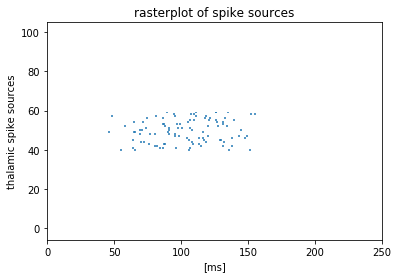

In [18]:
# make the thalamic input sources

popName = 'Thalamus'  

n_cells[popName] = n_cells['Exc']
spike_times = [[]]*n_cells[popName] #list of spike lists, where one spike list is related to one spike source
#random_sources_idx = [np.random.randint(n_cells[popName]*0.40, n_cells[popName]*0.60) for i in range(n_cells[popName])]
random_sources_idx = np.arange(int(n_cells[popName]*0.40), int(n_cells[popName]*0.60))

for idx, sources in enumerate(random_sources_idx):
    spike_times[sources] = np.sort([abs(np.random.normal(loc=100, scale=25)) for n in range(5)])


neuron_Model[popName] = sim.SpikeSourceArray(spike_times=spike_times)


pops[popName] = sim.Population(n_cells[popName], 
                           neuron_Model[popName],
                           label = popName)

proj['Thalamus', 'Exc'] = sim.Projection(pops['Thalamus'], 
                                         pops['Exc'],
                                         connector = sim.OneToOneConnector(),
                                         synapse_type = sim.StaticSynapse(weight=0.08, delay=1),
                                         receptor_type = 'excitatory',
                                         label = 'thalamus-exc connections')

fig, axes = plt.subplots(1,1)
axes_list = fig.axes
axes_list[0].eventplot(spike_times)
axes_list[0].set_xlabel('[ms]')
axes_list[0].set_ylabel('thalamic spike sources')
axes_list[0].set_title('rasterplot of spike sources')
axes_list[0].set_xlim(0, simtime)

random_sources_idx

In [21]:
# run simulation

sim.run(simtime) 

BrianObjectException: Error encountered with object named 'spikegeneratorgroup'.
Object was created here (most recent call only, full details in debug log):
  File '/home/alberto-int/anaconda3/lib/python3.7/site-packages/pyNN/brian2/cells.py', line 343, in __init__
    brian2.SpikeGeneratorGroup.__init__(self, n, indices=indices, times=times)

An error occurred when preparing an object. (See above for original error message and traceback.)

In [ ]:
# save the results
outputs = {}

for layer in ['Exc', 'Inh']:
    outputs[layer] = pops[layer].get_data()
    for recording in ['v', 'gsyn_inh', 'gsyn_exc', 'spikes']:
        pops[layer].write_data(fileName + '_' + str(layer) + '_' + str(recording) + '.pkl')

In [ ]:
# check results

def recover_results(outputs):
    results = {}
    for key in outputs.keys(): # to extract the name of the layer, e.g., Exc, Inh, Thalamus, etc  
        
        # to get voltage and conductances
        for analogsignal in outputs[key].segments[0].analogsignals:
            print(analogsignal.name)
            results[key, analogsignal.name] = analogsignal

        # to get spikes
        results[key, 'spikes'] = outputs[key].segments[0].spiketrains
    return results

results = recover_results(outputs)
results.keys()

In [ ]:
# check the spikes

fig, axes = plt.subplots(2, 1, figsize=(9,9))
fig.tight_layout(pad=5)
axes_list = fig.axes

for idx, value in enumerate(['Exc', 'Inh']):
    axes_list[idx].eventplot(results[value, 'spikes'])
    axes_list[idx].eventplot(spike_times, color='r')
    axes_list[idx].set_title('rasterplot of ' + str(value) + ' layer')
    axes_list[idx].set_xlabel('[ms]')
    axes_list[idx].set_ylabel('cells')
    axes_list[idx].set_xlim(0, simtime)


In [ ]:
# check the voltage

fig, axes = plt.subplots(2, 1, figsize=(9,9))
fig.tight_layout(pad=4)

axes_list = fig.axes

for idx, value in enumerate(['Exc', 'Inh']):
    im = axes_list[idx].imshow(results[value, 'v'].T)
    axes_list[idx].set_title('voltage of ' + str(value) + ' layer')
    axes_list[idx].set_xlabel('time [ms]')
    axes_list[idx].set_ylabel('cells')
    fig.colorbar(im, ax=axes_list[idx], fraction=0.010, label='[mV]')

In [ ]:
# check the conductances

for layer in ['Exc', 'Inh']:
    fig, axes = plt.subplots(2, 1, figsize=(9,9))
    fig.tight_layout(pad=4)
    fig.suptitle(str(layer) + ' layer')
    axes_list = fig.axes
    
    for idx, gsyn in enumerate(['gsyn_exc', 'gsyn_inh']):
        im = axes_list[idx].imshow(results[layer, gsyn].T)
        axes_list[idx].set_title(str(gsyn))
        axes_list[idx].set_xlabel('time [ms]')
        axes_list[idx].set_ylabel('cells')
        fig.colorbar(im, ax=axes_list[idx], fraction=0.010, label='[uS]')

In [ ]:
# end simulation

sim.end()

# task 1: on the stimulus

- go to the notebook cell '# make the thalamic input sources' and design and test a new type of thalamic input (e.g., more/sparser input cells, etc)
- find the critical limit of sequential spikes to get the network spiking

# task 2: on the state variables
 
- why does the condunctance related to inhibitory of the inhibitory layer is equal to zero?